# MobileNetV3 的核心创新点

## 1. 候选块（Candidate Block）与内积激活函数
- 使用**候选块**替代传统固定卷积单元，通过组合不同操作（卷积层、批标准化层、激活函数）提升灵活性
- 引入**内积激活函数**（如h-swish），在保持计算效率的同时增强非线性表达能力

<img src="resources/mobilenetv3_hswish.png" alt="drawing" width="40%"/>

## 2. 轻量化模块优化与 SE 注意力模块
- 在 MobileNetV2 的深度可分离卷积和残差结构基础上，新增**SE 模块**（Squeeze-and-Excitation），通过通道注意力机制动态调整特征权重，显著提升模型性能

## 3. 网络架构搜索（NAS）与 NetAdapt 联合优化
- 采用**互补搜索技术**：模块级搜索通过资源受限的 NAS 实现，局部搜索由 NetAdapt 完成，最终得到更高效的网络结构
- 通过 NAS 重新设计耗时层结构，进一步优化网络深度和宽度

## 4. 解码器改进（LR-ASPP）
- 针对图像分割任务，提出轻量级解码结构 **LR-ASPP**（Lite Reduced Atrous Spatial Pyramid Pooling），在减少计算量的同时保持多尺度特征融合能力

## 5. Bottleneck 结构升级
- 改进传统 bottleneck 结构，通过调整网络深度和宽度（如增加中间层通道数），在相同计算量下提升模型表达能力

---

这些创新点共同推动了 MobileNetV3 在移动端设备上的性能突破，具体可参考其论文和开源实现进一步验证

In [4]:
# 自动重新加载外部module，使得修改代码之后无需重新import
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

from hdd.device.utils import get_device

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# 设置训练数据的路径
DATA_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置TensorBoard的路径
TENSORBOARD_ROOT = "~/workspace/hands-dirty-on-dl/dataset"
# 设置预训练模型参数路径
TORCH_HUB_PATH = "~/workspace/hands-dirty-on-dl/pretrained_models"
torch.hub.set_dir(TORCH_HUB_PATH)
# 挑选最合适的训练设备
DEVICE = get_device(["cuda", "cpu"])
print("Use device: ", DEVICE)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Use device:  cuda


In [5]:
from hdd.dataset.imagenette_in_memory import ImagenetteInMemory

train_dataset = ImagenetteInMemory(
    root=DATA_ROOT,
    split="train",
    size="full",
    download=True,
    transform=None,
)
val_dataset = ImagenetteInMemory(
    root=DATA_ROOT,
    split="val",
    size="full",
    download=True,
    transform=None,
)

In [7]:
from hdd.data_util.auto_augmentation import ImageNetPolicy

from hdd.data_util.transforms import RandomResize
from torch.utils.data import DataLoader
from hdd.models.cnn.mobilenet_v3 import create_mobilenetV3
from hdd.train.classification_utils import (
    naive_train_classification_model,
)
from hdd.models.nn_utils import count_trainable_parameter


def train_net(
    net,
    train_dataloader,
    val_dataloader,
    lr=1e-3,
    weight_decay=1e-3,
    max_epochs=100,
) -> dict[str, list[float]]:
    print(f"#Parameter: {count_trainable_parameter(net)}")
    criteria = nn.CrossEntropyLoss(label_smoothing=0.1)
    optimizer = torch.optim.AdamW(net.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, max_epochs, eta_min=lr / 100
    )
    training_stats = naive_train_classification_model(
        net,
        criteria,
        max_epochs,
        train_dataloader,
        val_dataloader,
        DEVICE,
        optimizer,
        scheduler,
        verbose=True,
    )
    return training_stats


def build_dataloader(batch_size, train_dataset, val_dataset):
    train_dataloader = DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, num_workers=8
    )
    val_dataloader = DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, num_workers=8
    )
    return train_dataloader, val_dataloader


# 我们提前计算好了训练数据集上的均值和方差
TRAIN_MEAN = [0.4625, 0.4580, 0.4295]
TRAIN_STD = [0.2452, 0.2390, 0.2469]

stats = {}
net_names = ["mobilenet_v3_small", "mobilenet_v3_large"]
batch_sizes = [64, 32]
for net_name, batch_size in zip(net_names, batch_sizes):
    net = create_mobilenetV3(net_name, 1, 10, 0.5)
    net = net.to(DEVICE)
    train_dataset_transforms = transforms.Compose(
        [
            RandomResize([256, 288, 320, 352]),
            transforms.RandomCrop(224),
            transforms.RandomHorizontalFlip(),
            ImageNetPolicy(),
            transforms.ToTensor(),
            transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
        ]
    )
    train_dataset.transform = train_dataset_transforms
    val_dataset_transforms = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=TRAIN_MEAN, std=TRAIN_STD),
        ]
    )
    val_dataset.transform = val_dataset_transforms
    train_dataloader, val_dataloader = build_dataloader(
        batch_size, train_dataset, val_dataset
    )
    print(f"-----------------------{net_name}------------------------")
    max_epochs = 150
    stats[net_name] = train_net(
        net,
        train_dataloader,
        val_dataloader,
        lr=0.001,
        weight_decay=0,
        max_epochs=max_epochs,
    )
    del net

-----------------------mobilenet_v3_small------------------------
#Parameter: 1528106
Epoch: 1/150 Train Loss: 2.1417 Accuracy: 0.2393 Time: 4.89135  | Val Loss: 2.3124 Accuracy: 0.1006
Epoch: 2/150 Train Loss: 1.9063 Accuracy: 0.3785 Time: 4.85221  | Val Loss: 2.3260 Accuracy: 0.0986
Epoch: 3/150 Train Loss: 1.7884 Accuracy: 0.4383 Time: 4.94501  | Val Loss: 1.9843 Accuracy: 0.3623
Epoch: 4/150 Train Loss: 1.6715 Accuracy: 0.4948 Time: 4.92335  | Val Loss: 1.4127 Accuracy: 0.6252
Epoch: 5/150 Train Loss: 1.5984 Accuracy: 0.5293 Time: 4.86367  | Val Loss: 1.5025 Accuracy: 0.5860
Epoch: 6/150 Train Loss: 1.5115 Accuracy: 0.5651 Time: 4.84847  | Val Loss: 1.4318 Accuracy: 0.6288
Epoch: 7/150 Train Loss: 1.4641 Accuracy: 0.5886 Time: 4.86499  | Val Loss: 1.3167 Accuracy: 0.6571
Epoch: 8/150 Train Loss: 1.4288 Accuracy: 0.6038 Time: 4.88861  | Val Loss: 1.9676 Accuracy: 0.4721
Epoch: 9/150 Train Loss: 1.3767 Accuracy: 0.6276 Time: 4.86431  | Val Loss: 1.3327 Accuracy: 0.6662
Epoch: 10/150 

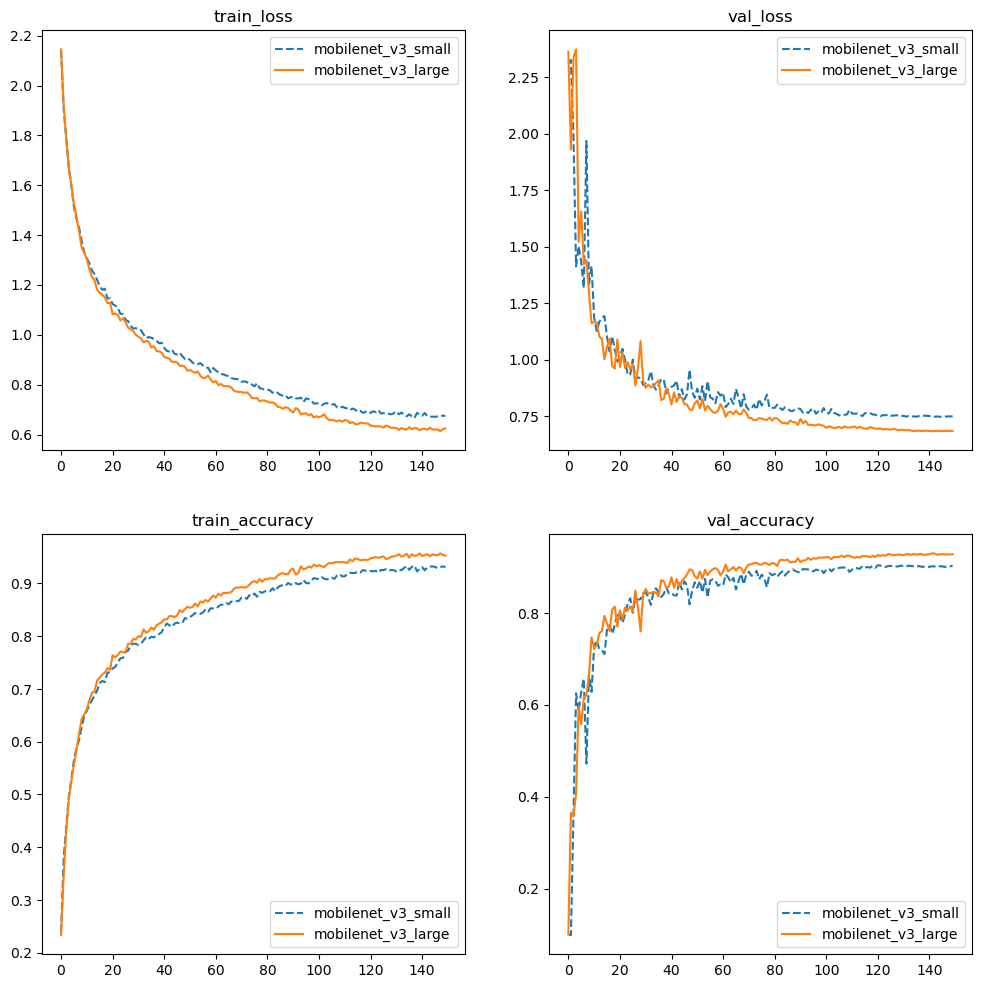

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(12,12))
fields = stats[net_names[0]].keys()
for i, field in enumerate(fields):
    plt.subplot(2, 2, i+1)
    plt.plot(stats[net_names[0]][field], label=net_names[0], linestyle="--")
    plt.plot(stats[net_names[1]][field], label=net_names[1])
    plt.legend()
    plt.title(field)